In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from model import VQTrEstimator

[2023-09-11 17:05:44,367] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
dataset = get_dataset("traffic")

In [3]:
estimator = VQTrEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*20,
    codebook_size=10,
    dim_head=8,
    nhead=2,
    depth=1,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=16,
    activation="gelu",

    num_feat_static_cat=1,
    cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)],
    embedding_dimension=[3],
    
    scaling=True,
  
    batch_size=256,
    num_batches_per_epoch=300,
    trainer_kwargs=dict(max_epochs=10,),
)

In [4]:
predictor = estimator.train(
    training_data=dataset.train,
    shuffle_buffer_length=512,
    cache_data=True,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you sh

Training: 0it [00:00, ?it/s]

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


ValidationError: 1 validation error for PyTorchPredictorModel
device
  str type expected (type=type_error.str)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [ ]:
forecasts = list(forecast_it)

In [ ]:
tss = list(ts_it)

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

In [11]:
agg_metrics

{'MSE': 0.0007588917167728698,
 'abs_error': 1510.6196669023484,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.682335099712742,
 'MAPE': 0.23270668692868818,
 'sMAPE': 0.200083345390462,
 'MSIS': 7.622576000348309,
 'QuantileLoss[0.1]': 741.0606117371707,
 'Coverage[0.1]': 0.028235830294995025,
 'QuantileLoss[0.2]': 1083.1264728931335,
 'Coverage[0.2]': 0.06096702021876036,
 'QuantileLoss[0.3]': 1307.2603137559786,
 'Coverage[0.3]': 0.10372472654955253,
 'QuantileLoss[0.4]': 1446.7393383803956,
 'Coverage[0.4]': 0.15889818804551983,
 'QuantileLoss[0.5]': 1510.619667229021,
 'Coverage[0.5]': 0.2317699701690421,
 'QuantileLoss[0.6]': 1519.5739814103135,
 'Coverage[0.6]': 0.3189909954701138,
 'QuantileLoss[0.7]': 1431.9300264244137,
 'Coverage[0.7]': 0.447816539608883,
 'QuantileLoss[0.8]': 1253.387549582594,
 'Coverage[0.8]': 0.6143658159319413,
 'QuantileLoss[0.9]': 950.9510665176377,
 'Coverage[0.9]': 0.8

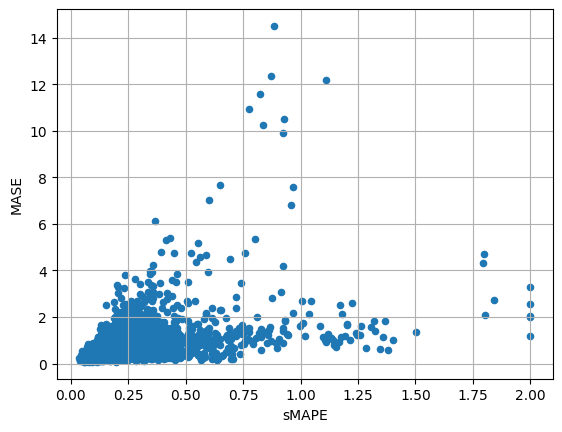

In [10]:
ts_metrics.plot(x='sMAPE', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

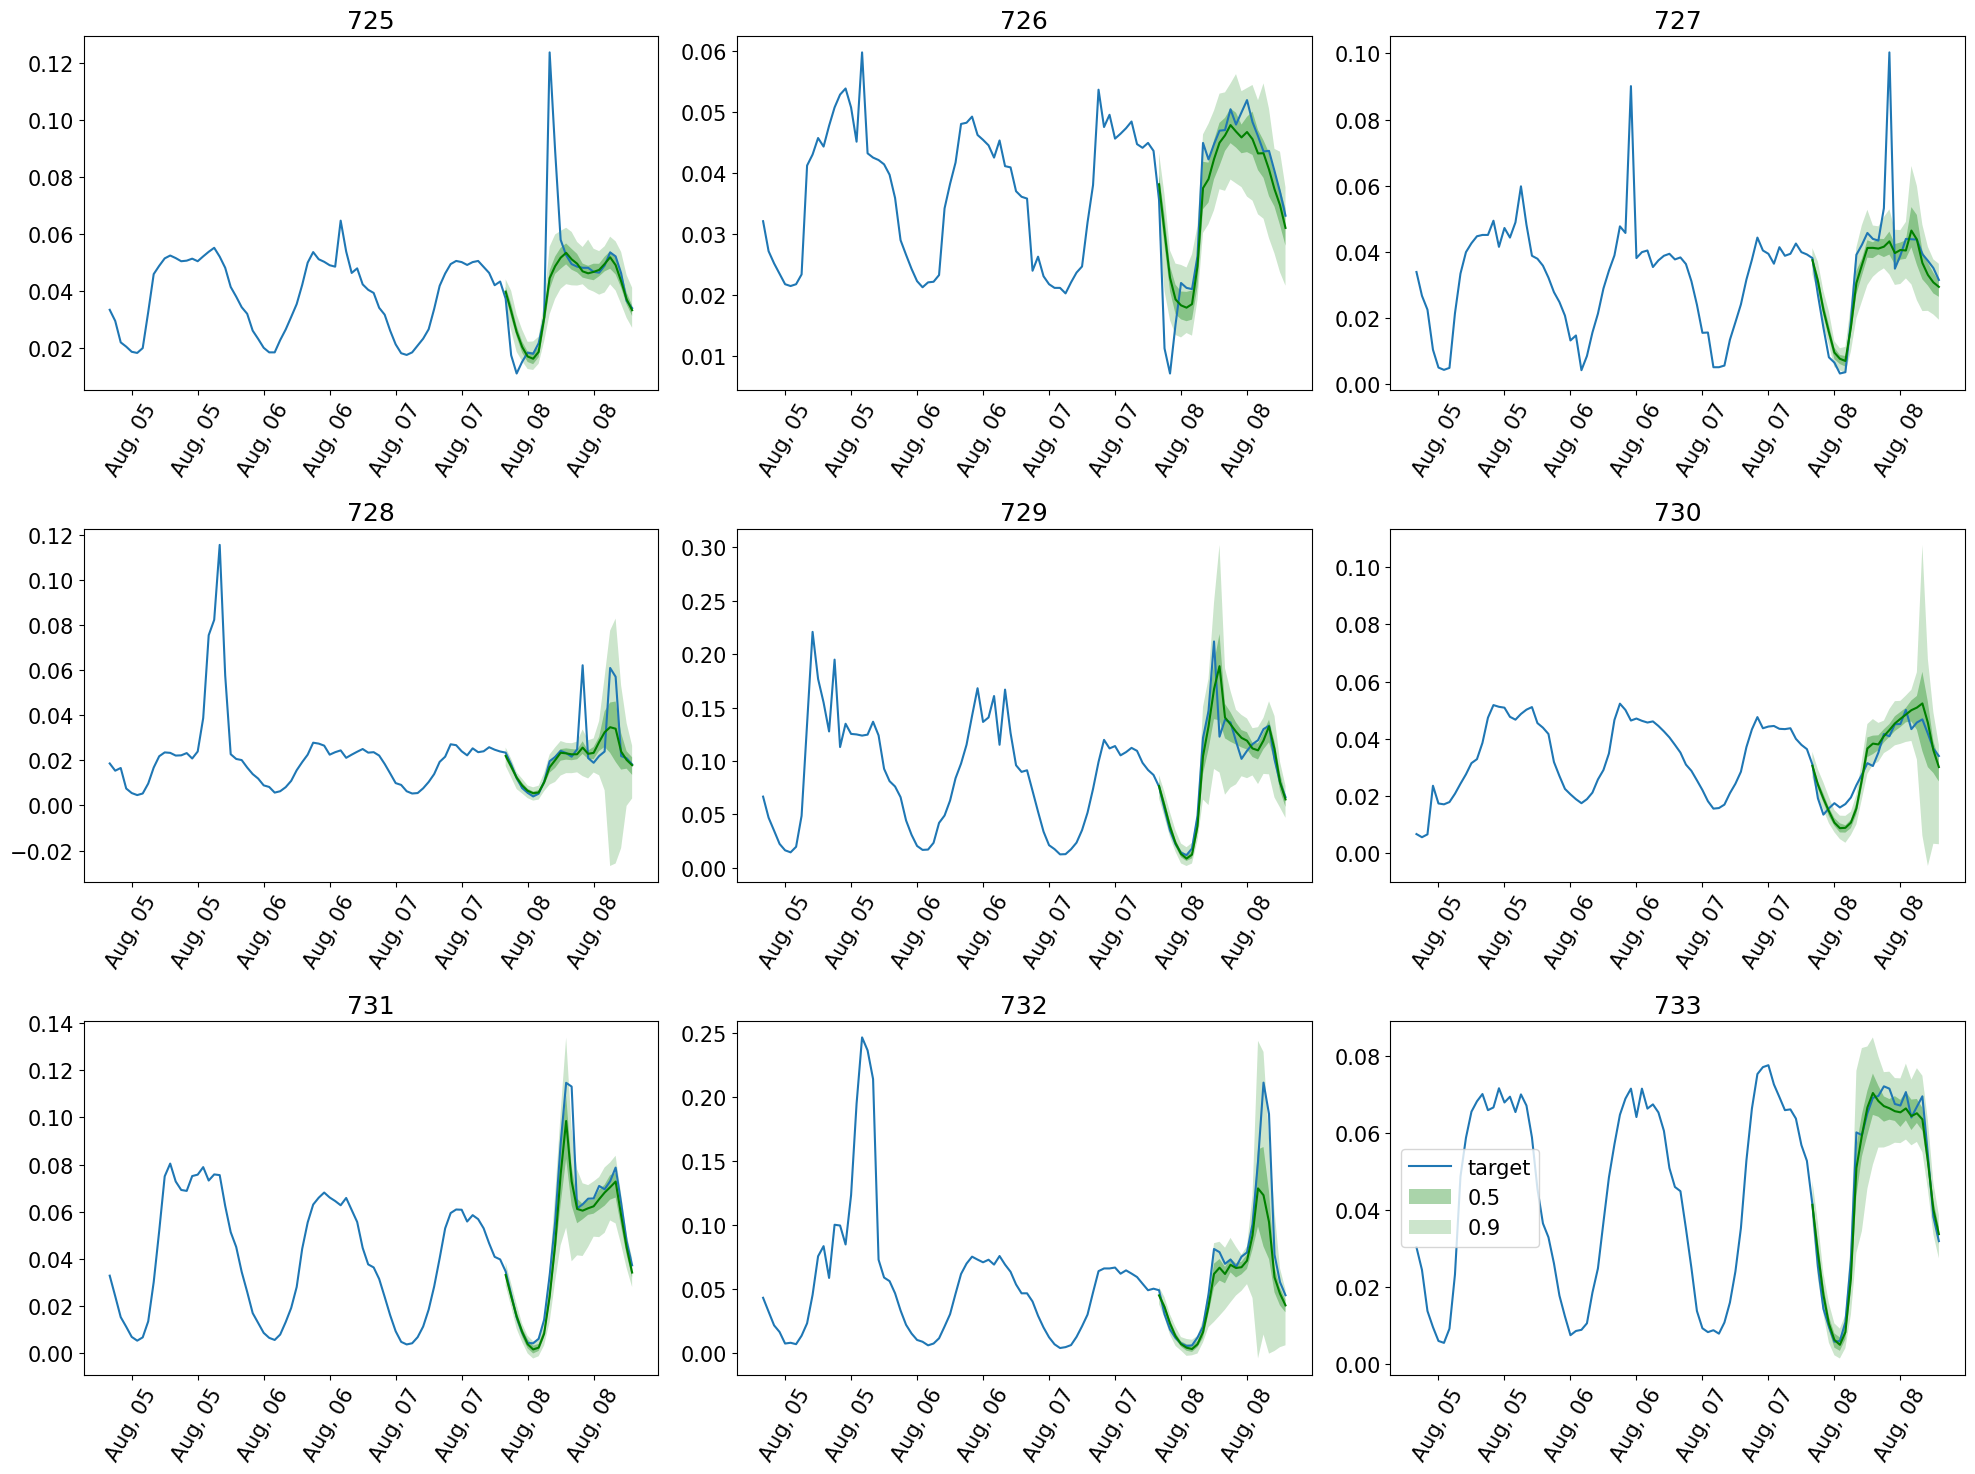

In [12]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 725, 725+9):
    ax = plt.subplot(3, 3, idx+1-725)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g', show_label=True)
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    plt.title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()